In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["QISKIT_IN_PARALLEL"] = 'TRUE'

In [3]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target


from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_lima")

In [5]:
from qiskit_experiments.test.iq_pulse_backend import SingleTransmonTestBackend
pulse_backend = SingleTransmonTestBackend()

# Calibration Experiments

In [6]:
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)

qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(backend, libraries=[library])

## fine amp

In [7]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal
amp_x_cal = FineXAmplitudeCal(qubit, cals, backend=backend, schedule_name="x")


## spectroscopy

In [20]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

freq01_estimate = backend.defaults().qubit_freq_est[2]
frequencies = np.linspace(freq01_estimate - 15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=backend)
spec.set_experiment_options(amp=0.005)

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

In [23]:
from qiskit.pulse.transforms import block_to_schedule

sch = block_to_schedule(list(list(spec._transpiled_circuits()[3].calibrations.values())[0].values())[0])


In [24]:
repr(sch)

'Schedule((0, ShiftFrequency(204404978.152, DriveChannel(0))), (0, Play(GaussianSquare(duration=1072, amp=(0.005+0j), sigma=256.0, width=0.0), DriveChannel(0))), (1072, ShiftFrequency(-204404978.152, DriveChannel(0))), name="spectroscopy")'

In [8]:
spec_data = spec.run().block_for_results()

/home/rupeshknn/miniconda3/envs/exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


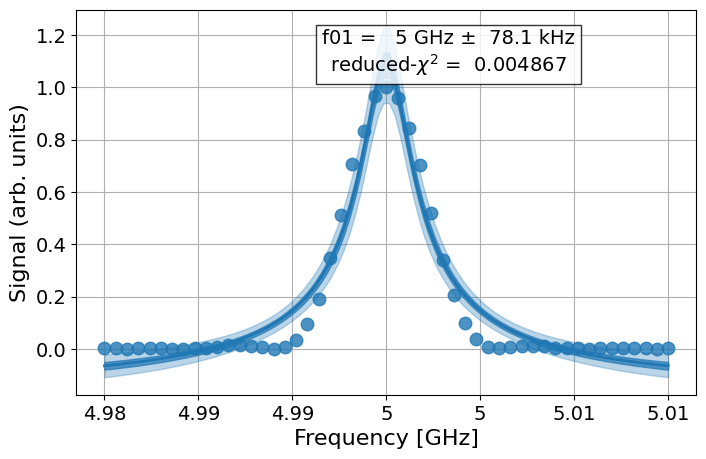

In [9]:
spec_data.figure(0)

In [10]:
print(spec_data.analysis_results("f01"))

AnalysisResult
- name: f01
- value: (5.00000+/-0.00008)e+09
- χ²: 0.004866668962915411
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False


## Rabi

In [44]:
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)

pulse_backend = SingleTransmonTestBackend()
qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

In [45]:
cals.add_parameter_value(320,'duration',(),schedule='x')

In [46]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

rabi = RoughXSXAmplitudeCal(
    qubit, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 51)
)

In [47]:
rabi.experiment_options

Options(amplitudes=array([-0.1  , -0.096, -0.092, -0.088, -0.084, -0.08 , -0.076, -0.072,
       -0.068, -0.064, -0.06 , -0.056, -0.052, -0.048, -0.044, -0.04 ,
       -0.036, -0.032, -0.028, -0.024, -0.02 , -0.016, -0.012, -0.008,
       -0.004,  0.   ,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,
        0.028,  0.032,  0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,
        0.06 ,  0.064,  0.068,  0.072,  0.076,  0.08 ,  0.084,  0.088,
        0.092,  0.096,  0.1  ]), schedule=ScheduleBlock(Play(Drag(duration=320, amp=amp, sigma=40, beta=0), DriveChannel(0)), name="x", transform=AlignLeft()), result_index=-1, group='default', angles_schedules=[AnglesSchedules(target_angle=3.141592653589793, parameter='amp', schedule='x', previous_value=None), AnglesSchedules(target_angle=1.5707963267948966, parameter='amp', schedule='sx', previous_value=None)])

In [52]:
rabi_data = rabi.run().block_for_results()

/home/rupeshknn/mambaforge/envs/exp/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


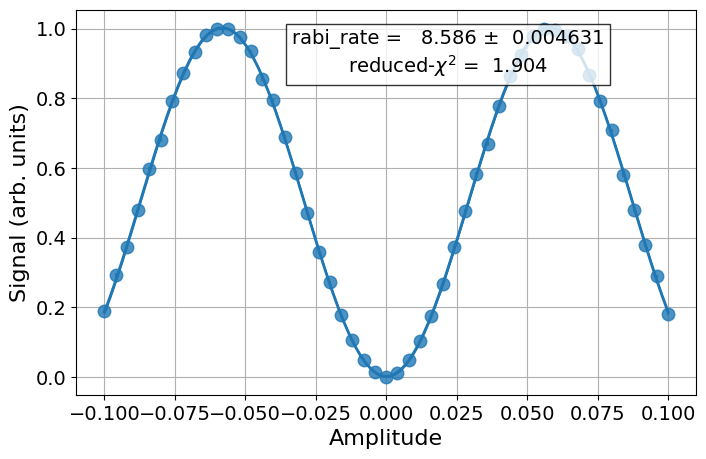

In [15]:
rabi_data.figure(0)

In [53]:
rabi_data.analysis_results(0).value.params["freq"]

12.846901636405821

In [10]:
rabi_data.analysis_results(0).value.params["freq"]

8.600939401305892

In [14]:
print(rabi_data.analysis_results("rabi_rate"))

AnalysisResult
- name: rabi_rate
- value: 8.594+/-0.005
- χ²: 2.211728618610856
- quality: good
- device_components: ['Q0']
- verified: False


In [15]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=160, amp=(0.02909134+0j), sigma=40, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [16]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=160, amp=(0.05818269+0j), sigma=40, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [55]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=240, amp=(0.03891989+0j), sigma=60, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [57]:
0.05818269 * 0.333

0.01937483577

In [61]:
(0.05818269/1.5)

-0.00013142999999999488